## Post processing after Matlab

Load the CSV once the Matlab detection is complete.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

df = pd.read_csv('20240329-5gL_5uM-SDS_50RH-1_1_detection.csv')
print(df.head())

   Frame     CenterX     CenterY    Radius    Metric  Remove
0     76  957.000000  557.126554  9.530163  0.275942       1
1     76  840.996631  666.618017  9.699721  0.224619       1
2     76  903.650315  748.722825  9.315300  0.213540       1
3     76  768.743893  699.000000  9.479582  0.209540       1
4     76  948.564160  647.366970  9.292992  0.203512       1


Let's plot all the detected circles for the 76th frame

In [11]:
df_filtered = df[df['Remove'] == 0]

In [12]:
def plot_bubbles_frame(num_frame):
    frame_df = df_filtered[df_filtered['Frame'] == num_frame]

    x_centers = frame_df['CenterX']
    y_centers = frame_df['CenterY']
    radii = frame_df['Radius']

    fig, ax = plt.subplots()
    for x, y, r in zip(x_centers, y_centers, radii):
        circle = plt.Circle((x, y), r, color='b', fill=False)
        ax.add_patch(circle)

    ax.set_aspect('equal', 'box')
    plt.xlim(min(x_centers) - max(radii), max(x_centers) + max(radii))
    plt.ylim(min(y_centers) - max(radii), max(y_centers) + max(radii))
    plt.xlabel('x')
    plt.ylabel('y')

    plt.xlim(0, 2048)
    plt.ylim(0, 2048)

    plt.title('Detected Circles for the {num_frame}th Frame'.format(num_frame=num_frame))
    plt.show()
    

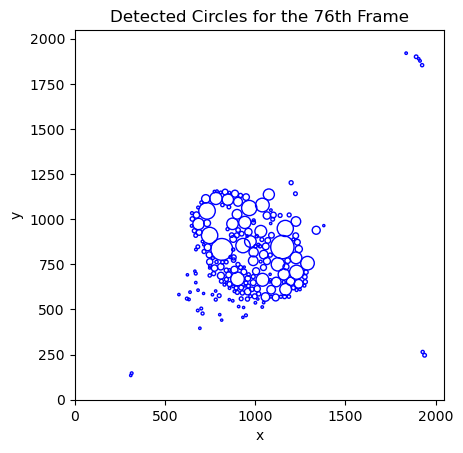

In [13]:
plot_bubbles_frame(76)

### Let's do raft classification.

We look at the bubble circonference, for both bubbles if some points are close like something below the minimum of both bubbles' radii, we say there are in a raft.

Now we compute the minimal distance between closest points for both circles

In [22]:
def circle_min_distance(x1, y1, r1, x2, y2, r2):
    """
    Computing minimal distance between two circles.
    """
    d_centers = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return max(0, d_centers - (r1 + r2))

Now let's think in term of graph processing to do a cluster classification.

In [33]:
def raft_classification_graph(df_frame):
    circles = df_frame[['CenterX', 'CenterY', 'Radius']].values
    n = len(circles)
    adjacency = [[] for _ in range(n)]
    
    for i in range(n):
        x1, y1, r1 = circles[i]
        for j in range(i + 1, n):
            x2, y2, r2 = circles[j]
            dist = circle_min_distance(x1, y1, r1, x2, y2, r2)
            if dist < min(r1, r2):
                adjacency[i].append(j)
                adjacency[j].append(i)
    
    visited = set()
    rafts = []
    for i in range(n):
        if i not in visited:
            stack = [i]
            visited.add(i)
            comp = []
            while stack:
                node = stack.pop()
                comp.append(node)
                for neighbor in adjacency[node]:
                    if neighbor not in visited:
                        visited.add(neighbor)
                        stack.append(neighbor)
            rafts.append(comp)
    
    return rafts

rafts_graph = raft_classification_graph(df_filtered_76)
print(rafts_graph)

[[0], [1, 50], [2, 201, 178, 191, 195, 208, 188, 172, 148, 176, 184, 165, 206, 166, 117, 163, 107, 190, 164, 110, 105, 121, 109, 207, 204, 199, 205, 125, 168, 200, 203, 84, 192, 186, 187, 140, 157, 120, 179, 202, 196, 197, 193, 153, 112, 119, 94, 36, 170, 158, 19, 34, 5, 175, 72, 52, 22, 156, 87, 86, 30, 143, 101, 138, 182, 106, 98, 46, 132, 85, 83, 10, 65, 48, 124, 91, 194, 20, 81, 171, 159, 150, 127, 54, 14, 108, 142, 161, 95, 7, 62, 57, 126, 80, 155, 133, 144, 122, 97, 74, 39, 24, 89, 63, 37, 160, 152, 139, 115, 93, 43, 59, 135, 70, 128, 47, 104, 3, 90, 114, 113, 173, 141, 79, 33, 92, 64, 147, 82, 69, 151, 134, 25, 183, 154, 149, 146, 145, 137, 123, 4, 167, 162, 189, 185, 169, 116, 100, 99, 51, 40, 23, 177, 136, 129, 12, 9, 198, 181, 180], [6], [8], [11], [13, 102], [15], [16, 60], [17], [18], [21], [26], [27], [28], [29], [31], [32], [35], [38], [41], [42, 73], [44], [45], [49], [53, 71, 68], [55], [56], [58], [61], [66], [67], [75, 78], [76], [77], [88], [96], [103], [111], [118],

/var/folders/_5/450_dsxx7pqfnwb2rs5wpndm0000gn/T/ipykernel_63217/1043199971.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(rafts_graph))


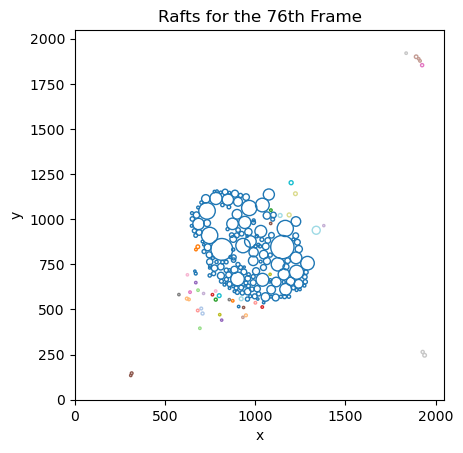

In [34]:
colors = plt.cm.get_cmap('tab20', len(rafts_graph))

fig, ax = plt.subplots()
for i, raft in enumerate(rafts_graph):
    for idx in raft:
        x = df_filtered_76.iloc[idx]['CenterX']
        y = df_filtered_76.iloc[idx]['CenterY']
        r = df_filtered_76.iloc[idx]['Radius']
        circle = plt.Circle((x, y), r, color=colors(i), fill=False)
        ax.add_patch(circle)

ax.set_aspect('equal', 'box')
plt.xlim(0, 2048)
plt.ylim(0, 2048)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rafts for the 76th Frame')
plt.show()

In [36]:
print("Number of detected clusters:", len(rafts_graph))

Number of detected clusters: 43


#### **Refinement.** How big is a cluster so that it has an influence on the bursting ?

Say that we have an important cluster if we have at least 5 connected bubbles.

In [37]:
threshold = 5
important_clusters = [raft for raft in rafts_graph if len(raft) >= threshold]
small_clusters = [raft for raft in rafts_graph if 1 < len(raft) < threshold]
bulk_clusters = [raft for raft in rafts_graph if len(raft) == 1]

print("Important clusters (>=5 bubbles):", important_clusters)
print("Small clusters (<5 bubbles):", small_clusters)
print("Bulk clusters (1 bubble):", bulk_clusters)

Important clusters (>=5 bubbles): [[2, 201, 178, 191, 195, 208, 188, 172, 148, 176, 184, 165, 206, 166, 117, 163, 107, 190, 164, 110, 105, 121, 109, 207, 204, 199, 205, 125, 168, 200, 203, 84, 192, 186, 187, 140, 157, 120, 179, 202, 196, 197, 193, 153, 112, 119, 94, 36, 170, 158, 19, 34, 5, 175, 72, 52, 22, 156, 87, 86, 30, 143, 101, 138, 182, 106, 98, 46, 132, 85, 83, 10, 65, 48, 124, 91, 194, 20, 81, 171, 159, 150, 127, 54, 14, 108, 142, 161, 95, 7, 62, 57, 126, 80, 155, 133, 144, 122, 97, 74, 39, 24, 89, 63, 37, 160, 152, 139, 115, 93, 43, 59, 135, 70, 128, 47, 104, 3, 90, 114, 113, 173, 141, 79, 33, 92, 64, 147, 82, 69, 151, 134, 25, 183, 154, 149, 146, 145, 137, 123, 4, 167, 162, 189, 185, 169, 116, 100, 99, 51, 40, 23, 177, 136, 129, 12, 9, 198, 181, 180]]
Small clusters (<5 bubbles): [[1, 50], [13, 102], [16, 60], [42, 73], [53, 71, 68], [75, 78]]
Bulk clusters (1 bubble): [[0], [6], [8], [11], [15], [17], [18], [21], [26], [27], [28], [29], [31], [32], [35], [38], [41], [44], [

**Classification**
- 1 bubble : bulk
- 2 to 4 bubbles : low cluster
- 5 bubbles and above : high cluster

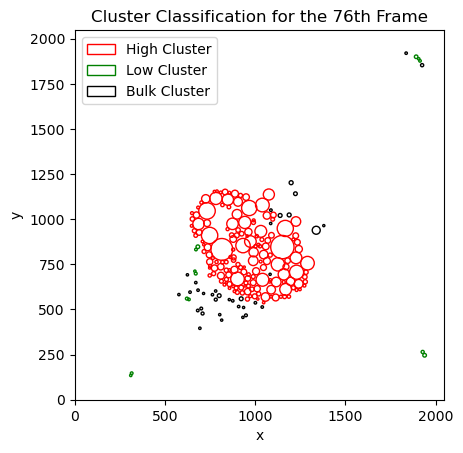

In [38]:
fig, ax = plt.subplots()

i1=0
# Plot high clusters in red
for raft in important_clusters:
    for idx in raft:
        x = df_filtered_76.iloc[idx]['CenterX']
        y = df_filtered_76.iloc[idx]['CenterY']
        r = df_filtered_76.iloc[idx]['Radius']
        if i1==0:
            circle = plt.Circle((x, y), r, color='red', fill=False, label='High Cluster')
            i1 += 1
        else:
            circle = plt.Circle((x, y), r, color='red', fill=False)
        ax.add_patch(circle)

# Plot low clusters in green
i2 = 0
for raft in small_clusters:
    for idx in raft:
        x = df_filtered_76.iloc[idx]['CenterX']
        y = df_filtered_76.iloc[idx]['CenterY']
        r = df_filtered_76.iloc[idx]['Radius']
        if i2==0:
            circle = plt.Circle((x, y), r, color='green', fill=False, label='Low Cluster')
            i2 += 1
        else:
            circle = plt.Circle((x, y), r, color='green', fill=False)
        ax.add_patch(circle)

i3 = 0
# Plot bulk bubbles in black
for raft in bulk_clusters:
    for idx in raft:
        x = df_filtered_76.iloc[idx]['CenterX']
        y = df_filtered_76.iloc[idx]['CenterY']
        r = df_filtered_76.iloc[idx]['Radius']
        if i3 == 0:
            circle = plt.Circle((x, y), r, color='black', fill=False, label='Bulk Cluster')
            i3 += 1
        else:
            circle = plt.Circle((x, y), r, color='black', fill=False)
        ax.add_patch(circle)

ax.set_aspect('equal', 'box')
plt.xlim(0, 2048)
plt.ylim(0, 2048)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cluster Classification for the 76th Frame')
plt.show()